# Cho dữ liệu champagne_new.xlsx là dữ liệu bán champagne theo thời gian từ tháng 01-1964 đến tháng 09-1972
Yêu cầu: Đọc dữ liệu, chuẩn hóa dữ liệu (nếu cần) và chọn một thuật toán Time Series thích hợp để thực hiện việc dự đoán số tiền champagne bán được của 9 tháng tiếp theo từ tháng 10-1972 đến tháng 06-1973 giá trị dựa trên các thông tin được cung cấp
1. Thực hiện Decomposition, trực quan hóa, nhận xét.
2. Tạo dữ liệu train/test với train chiếm 75% dữ liệu, test chiếm 25% dữ liệu.
3. Áp dụng thuật toán phù hợp.
4. Tìm kết quả.
5. Trực quan hóa kết quả (trong biểu đồ có cả train, test, predict và next_9_months).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_excel('./du lieu cung cap/champagne_new.xlsx',index_col=0)

In [3]:
data.index = pd.to_datetime(data.index)
data.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq=None)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   monthly_champange  105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [5]:
data.head()

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
data.head()

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


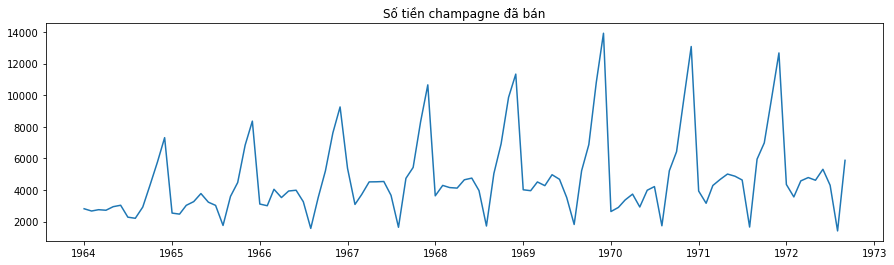

In [7]:
plt.figure(figsize=(15,4))
plt.plot(data)
plt.title('Số tiền champagne đã bán');

##### Nhận xét:
Doanh số bán champagne tăng dần đều từ 1964-1979 và có xu hướng ổn định sau năm 1970.(Có thể sử dụng mô hình nhân để phân tích bao quát lịch sử bán hàng)

### Thực hiện Decomposition, trực quan hóa, nhận xét.

In [8]:
result = seasonal_decompose(data,model='multiplicative')
result

c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


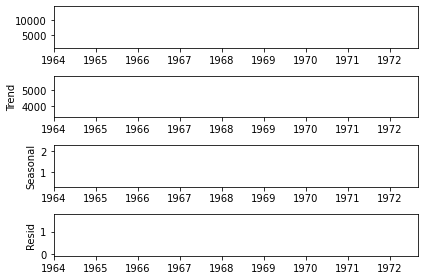

In [9]:
result.plot()
plt.show();

##### Nhận xét:
- Trend: Xu hướng tăng dần đến giữa năm 1969 và sau đó có xu hướng biến động từ giữa 1969 đến 1972, sau 1972 doanh thu ổn định.
- Seasonal: Biều đồ có tính tính chất theo mùa.
- Residual: Nhìn chung khá ổn định, chỉ có một số thay đổi đột ngột nhất thời.

### Tạo dữ liệu train/test với train chiếm 75% dữ liệu, test chiếm 25% dữ liệu.

In [10]:
round(data.shape[0]*0.75)

79

In [11]:
train = data.iloc[:79,0]
test = data.iloc[79:,0]

### Áp dụng thuật toán phù hợp

##### Áp dụng Arima:

In [12]:
arima_model = auto_arima(data,start_p=2,start_q=2,
                           max_p=5,max_q=5,m=12,
                           start_P=1,seasonal=True,
                           error_action='ignore',suppress_warnings=True,stepwise=True)

In [13]:
arima_model.aic()

1498.1667652453318

In [14]:
arima_model.fit(train)

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True)

In [15]:
arima_pred = arima_model.predict(n_periods=len(test))

In [16]:
print('mae :', mean_absolute_error(test,arima_pred))
print('mse :', mean_squared_error(test,arima_pred))

mae : 750.7847134904309
mse : 812260.735823016


##### Áp dụng HoltWinter:

In [17]:
holtwinter_model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12).fit()

c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [18]:
s = data.iloc[79:,0].index[0]
e = data.iloc[79:,0].index[-1]

In [19]:
holtwinter_pred = holtwinter_model.predict(start =s, end=e)

In [20]:
print('mae :', mean_absolute_error(test,holtwinter_pred))
print('mse :', mean_squared_error(test,holtwinter_pred))

mae : 773.1559234229227
mse : 827917.7458229909


##### Nhận xét:
Từ kết quả mse và mae ta nhận thấy thuật toán Arima phù hợp hơn trong việc dự đoán doanh thu Champagne. 

### Tìm kết quả.

In [21]:
arima_model.fit(data)

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True)

In [22]:
next_9_months = arima_model.predict(n_periods=9)
next_9_months

array([ 7199.90806558, 10212.23371369, 13105.28518185,  4636.96661826,
        3855.10786553,  4887.9144028 ,  5130.85467461,  5050.78706003,
        5596.68412372])

### Trực quan hóa kết quả (trong biểu đồ có cả train, test, predict và next_9_months).

In [23]:
months = pd.date_range('1972-10-01','1973-06-01',freq='MS').strftime('%Y-%m-%d').tolist()

In [24]:
predict_9_months = pd.DataFrame(next_9_months,index=months)
predict_9_months

,0
1972-10-01,7199.908066
1972-11-01,10212.233714
1972-12-01,13105.285182
1973-01-01,4636.966618
1973-02-01,3855.107866
1973-03-01,4887.914403
1973-04-01,5130.854675
1973-05-01,5050.787060
1973-06-01,5596.684124


In [25]:
predict_9_months.index = pd.to_datetime(predict_9_months.index)

c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\nguye\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\converter

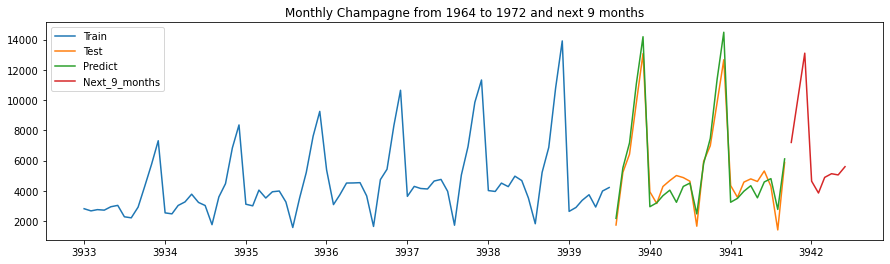

In [26]:
plt.figure(figsize=(15,4))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(test.index,arima_pred,label='Predict')
plt.plot(predict_9_months.index,predict_9_months,label='Next_9_months')
plt.title('Monthly Champagne from 1964 to 1972 and next 9 months')
plt.legend();

##### Nhận xét:
    - Theo biểu đồ ta thấy mô hình dự đoán bám tốt với doanh thu thực tế ở những mùa doanh thu cao, ở những mùa doanh thu giảm có sự chênh lệch hơn do nhiều biến động. 